In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **CS224W - Colab 4**

In this Colab, we will shift our focus from homogenous graphs to heterogeneous graphs. Heterogeneous graphs extend the traditional homogenous graphs that we have seen before by specifically incorperating different node and edge types. This additional information allows us to extend the graph neural nework models that we have worked with before. Namely, we can apply heterogenous message passing, where different message types now exist between different node, edge type relationships.   
在这个 Colab 中，我们将把注意力从同构图转移到异构图。异构图通过专门合并不同的节点和边类型，扩展了我们之前看到的传统同构图。这些附加信息使我们能够扩展我们之前使用过的图神经网络模型。也就是说，我们可以应用异构消息传递，其中不同的节点、边缘类型关系之间现在存在不同的消息类型。

At first, we will learn how to transform NetworkX graphs into DeepSNAP representations. Additionally, we will dive deeper into how DeepSNAP stores and represents heterogeneous graphs as PyTorch Tensors.  
首先，我们将学习如何将 NetworkX 图转换为 DeepSNAP 表示。此外，我们将深入探讨 DeepSNAP 如何将异构图存储和表示为 PyTorch 张量。

Then, we will build our own heterogenous graph neural netowrk models using PyTorch Geonetric and DeepSNAP on node property prediction task. To evaluate these models, we will use our model on the heterogeneous ACM dataset.  
然后，我们将在节点属性预测任务上使用 PyTorch Geonetric 和 DeepSNAP 构建我们自己的异构图神经网络模型。为了评估这些模型，我们将在异构 ACM 数据集上使用我们的模型。

**Note**: Make sure to **sequentially run all the cells in each section**, so that the intermediate variables / packages will carry over to the next cell  
注意：确保顺序运行每个部分中的所有单元格，以便中间变量/包会延续到下一个单元格

Have fun on Colab 4 :)

# Device
You might need to use GPU for this Colab.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

# Installation

In [2]:
import torch
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 1.9.0+cu102


In [3]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html       # 1.7.0+cu101
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git
!pip install -U -q PyDrive

     |████████████████████████████████| 2.6MB 7.2MB/s 
     |████████████████████████████████| 1.4MB 7.7MB/s 
     |████████████████████████████████| 225kB 7.7MB/s 
     |████████████████████████████████| 235kB 12.9MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 


In [4]:
import torch_geometric
torch_geometric.__version__

'1.7.2'

# 1 DeepSNAP Heterogeneous Graph 
DeepSNAP 异构图

First, we will explore how to transform NetworkX graphs into the format supported by DeepSNAP.   
首先，我们将探讨如何将 NetworkX 图转换为 DeepSNAP 支持的格式。

In order to extend the traditional DeepSNAP representation of graphs to include heterogenous graphs, we include the following graph property features:  
为了扩展图的传统 DeepSNAP 表示以包含异构图，我们包含以下图属性特征：
* `node_feature`: The feature of each node (`torch.tensor`)
* `edge_feature`: The feautre of each edge (`torch.tensor`)
* `node_label`: The label of each node (`int`)
* `node_type`: The node type of each node (`string`)
* `edge_type`: The edge type of each edge (`string`)

The key new features we add are `node_type` and `edge_type`, which enables us to perform heterogenous message passing.  
我们添加的关键新特性是 `node_type` 和 `edge_type`，它们使我们能够执行异构消息传递。

In this first question we will work with the familiar [karate club graph](https://networkx.github.io/documentation/stable/auto_examples/graph/plot_karate_club.html) seen in assignment one. To start, since each node in the graph belongs to one of two clubs (club "Mr. Hi" or club "Officer"), we will treat the club as the `node_type`. The code below demonstrates how to differentiate the nodes in the NetworkX graph.  
在第一个问题中，我们将使用在作业一中看到的熟悉的空手道俱乐部图表。 首先，由于图中的每个节点都属于两个俱乐部之一（俱乐部“Mr. Hi”或俱乐部“Officer”），我们将俱乐部视为 node_type。 下面的代码演示了如何区分 NetworkX 图中的节点。


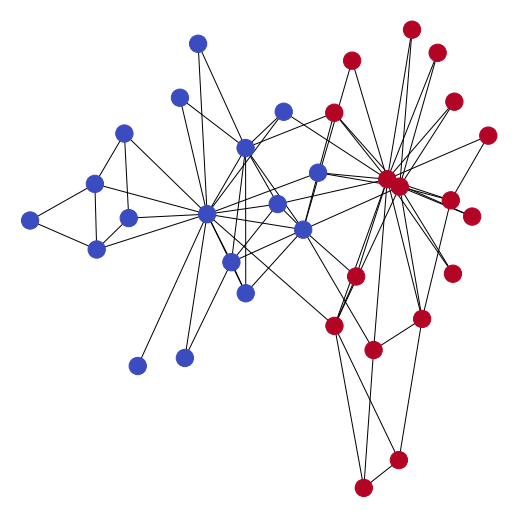

In [5]:
from pylab import *
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import copy

G = nx.karate_club_graph()
community_map = {}
for node in G.nodes(data=True):
  if node[1]["club"] == "Mr. Hi":
    community_map[node[0]] = 0
  else:
    community_map[node[0]] = 1
node_color = []
color_map = {0: 0, 1: 1}
node_color = [color_map[community_map[node]] for node in G.nodes()]
pos = nx.spring_layout(G)
plt.figure(figsize=(7, 7))
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color)
show()

### Question 1.1: Assigning Node Type and Node Features (Not Specifically Graded)  
问题 1.1：分配节点类型和节点特征（未具体分级）

Using the `community_map` dictionary and graph `G` from above, add node attributes `node_type` and `node_label` to the graph G. Namely, for `node_type` assign nodes in the "Mr. Hi" club to a node type `n0` and nodes in club "Officer" a node type `n1`.   
使用上面的 community_map 字典和图 G，将节点属性 node_type 和 node_label 添加到图 G。 即，对于 node_type，将“先生”俱乐部中的节点分配给节点类型 n0，将“官员”俱乐部中的节点分配给节点类型 n1。

Then for `node_label`, assign nodes in "Mr. Hi" club to a `node_label` `0` and nodes in club "Officer" a `node_label` of `1`.  
然后对于 node_label，将“Mr. Hi”俱乐部中的节点分配给 node_label 0，将“Officer”俱乐部中的节点分配为 node_label 1。

Lastly, assign every node a feature vector [1, 1, 1, 1, 1].   
最后，为每个节点分配一个特征向量 [1, 1, 1, 1, 1]。

**Hint**: Look at the NetworkX function `nx.classes.function.set_node_attributes`.  
提示：查看 NetworkX 函数 nx.classes.function.set_node_attributes。

**Note**: This question is not specifically graded but is important for later questions.  
注意：这个问题没有专门评分，但对以后的问题很重要。

In [6]:
#PRW
for node in G.nodes(data=True):
    print(node)
    print(node[0])
    print(node[1])
    break

(0, {'club': 'Mr. Hi'})
0
{'club': 'Mr. Hi'}


In [7]:
#PRW
for node in G.nodes():
    print(node)
    break

0


In [8]:
#PRW
#上文提及函数的文档：https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.set_node_attributes.html
#文档示例1
G_eg = nx.path_graph(3)
bb = nx.betweenness_centrality(G)  #bb是一个字典

nx.set_node_attributes(G_eg, bb, "betweenness")
G_eg.nodes[1]["betweenness"]

0.053936688311688304

In [9]:
#PRW
new_cm={}
for (k,v) in community_map.items():
    if v==0:
        new_cm[k]='n0'
    else:
        new_cm[k]='n1'
#new_cm

In [10]:
import torch

def assign_node_types(G, community_map):
  # TODO: Implement this function that takes in a NetworkX graph
  # G and community map assignment (mapping node ids --> 0/1 labels)
  # and adds 'node_type' as a node_attribute in G.

  ############# Your code here ############
  ## (~2 line of code)
  ## Note
  ## 1. Look up NetworkX `nx.classes.function.set_node_attributes`
  values = {}
  for node in G.nodes(data=True):
      if community_map[node[0]] == 0:
          values[node[0]] = 'n0'
      else:
          values[node[0]] = 'n1'
  nx.classes.function.set_node_attributes(G, values, name='node_type')

  #########################################

def assign_node_labels(G, community_map):
  # TODO: Implement this function that takes in a NetworkX graph
  # G and community map assignment (mapping node ids --> 0/1 labels)
  # and adds 'node_label' as a node_attribute in G.

  ############# Your code here ############
  ## (~2 line of code)
  ## Note
  ## 1. Look up NetworkX `nx.classes.function.set_node_attributes`
  nx.classes.function.set_node_attributes(G, community_map, name='node_label')

  #########################################

def assign_node_features(G):
  # TODO: Implement this function that takes in a NetworkX graph
  # G and adds 'node_feature' as a node_attribute in G. Each node
  # in the graph has the same feature vector [1., 1., 1., 1., 1.]

  ############# Your code here ############
  ## (~2 line of code)
  ## Note
  ## 1. Look up NetworkX `nx.classes.function.set_node_attributes`
  nx.classes.function.set_node_attributes(G, [1., 1., 1., 1., 1.], name='node_feature')

  #########################################

assign_node_types(G, community_map)
assign_node_labels(G, community_map)
assign_node_features(G)

for node in G.nodes(data=True):
    print(node)

(0, {'club': 'Mr. Hi', 'node_type': 'n0', 'node_label': 0, 'node_feature': [1.0, 1.0, 1.0, 1.0, 1.0]})
(1, {'club': 'Mr. Hi', 'node_type': 'n0', 'node_label': 0, 'node_feature': [1.0, 1.0, 1.0, 1.0, 1.0]})
(2, {'club': 'Mr. Hi', 'node_type': 'n0', 'node_label': 0, 'node_feature': [1.0, 1.0, 1.0, 1.0, 1.0]})
(3, {'club': 'Mr. Hi', 'node_type': 'n0', 'node_label': 0, 'node_feature': [1.0, 1.0, 1.0, 1.0, 1.0]})
(4, {'club': 'Mr. Hi', 'node_type': 'n0', 'node_label': 0, 'node_feature': [1.0, 1.0, 1.0, 1.0, 1.0]})
(5, {'club': 'Mr. Hi', 'node_type': 'n0', 'node_label': 0, 'node_feature': [1.0, 1.0, 1.0, 1.0, 1.0]})
(6, {'club': 'Mr. Hi', 'node_type': 'n0', 'node_label': 0, 'node_feature': [1.0, 1.0, 1.0, 1.0, 1.0]})
(7, {'club': 'Mr. Hi', 'node_type': 'n0', 'node_label': 0, 'node_feature': [1.0, 1.0, 1.0, 1.0, 1.0]})
(8, {'club': 'Mr. Hi', 'node_type': 'n0', 'node_label': 0, 'node_feature': [1.0, 1.0, 1.0, 1.0, 1.0]})
(9, {'club': 'Officer', 'node_type': 'n1', 'node_label': 1, 'node_feature

In [11]:
#PRW验证函数效果
for n in G.nodes(data=True):
    print(n)
    break

(0, {'club': 'Mr. Hi', 'node_type': 'n0', 'node_label': 0, 'node_feature': [1.0, 1.0, 1.0, 1.0, 1.0]})


### Question 1.2: Assigning Edge Types (Not Specifically Graded)  
问题 1.2：分配边缘类型（未具体分级）

Next, we will assign three different types of `edge_type` to the edges:   
接下来，我们将为边分配三种不同类型的 edge_type：
* Edges within club "Mr. Hi": `e0`
* Edges within club "Officer": `e1`
* Edges between clubs: `e2`

**Hint**: Use the `community_map` from before and `nx.classes.function.set_edge_attributes`  
提示：使用之前的 community_map 和 nx.classes.function.set_edge_attributes

In [12]:
#PRW
#上文提及函数的文档：https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.set_edge_attributes.html

for edge in G.edges():
    print(edge)
    print(edge[0])
    break

(0, 1)
0


In [13]:
#PRW
G.nodes[0]['club']

'Mr. Hi'

In [14]:
edge2attr_map={}
for edge in G.edges():
    if G.nodes[edge[0]]['club']=='Mr. Hi' and G.nodes[edge[1]]['club']=='Mr. Hi':
        edge2attr_map[edge]='e0'
    elif G.nodes[edge[0]]['club']=='Officer' and G.nodes[edge[1]]['club']=='Officer':
        edge2attr_map[edge]='e1'
    else:
        edge2attr_map[edge]='e2'
edge2attr_map[(0,1)]

'e0'

In [15]:
def assign_edge_types(G, community_map):
  # TODO: Implement this function that takes in a NetworkX graph
  # G and community map assignment (mapping node ids --> 0/1 labels)
  # and adds 'edge_type' as a edge_attribute in G.

  ############# Your code here ############
  ## (~5 line of code)
  ## Note
  ## 1. Create an edge assignment dict following rules above
  values = {}
  for edge in G.edges(data=True):
    if community_map[edge[0]] == 0 and community_map[edge[1]] == 0:
      values[(edge[0], edge[1])] = 'e0'
    elif community_map[edge[0]] == 1 and community_map[edge[1]] == 1:
      values[(edge[0], edge[1])] = 'e1'
    else:
      values[(edge[0], edge[1])] = 'e2'
  nx.classes.function.set_edge_attributes(G, values, name='edge_type')

  #########################################

assign_edge_types(G, community_map)

for edge in G.edges(data=True):
    print(edge)

(0, 1, {'edge_type': 'e0'})
(0, 2, {'edge_type': 'e0'})
(0, 3, {'edge_type': 'e0'})
(0, 4, {'edge_type': 'e0'})
(0, 5, {'edge_type': 'e0'})
(0, 6, {'edge_type': 'e0'})
(0, 7, {'edge_type': 'e0'})
(0, 8, {'edge_type': 'e0'})
(0, 10, {'edge_type': 'e0'})
(0, 11, {'edge_type': 'e0'})
(0, 12, {'edge_type': 'e0'})
(0, 13, {'edge_type': 'e0'})
(0, 17, {'edge_type': 'e0'})
(0, 19, {'edge_type': 'e0'})
(0, 21, {'edge_type': 'e0'})
(0, 31, {'edge_type': 'e2'})
(1, 2, {'edge_type': 'e0'})
(1, 3, {'edge_type': 'e0'})
(1, 7, {'edge_type': 'e0'})
(1, 13, {'edge_type': 'e0'})
(1, 17, {'edge_type': 'e0'})
(1, 19, {'edge_type': 'e0'})
(1, 21, {'edge_type': 'e0'})
(1, 30, {'edge_type': 'e2'})
(2, 3, {'edge_type': 'e0'})
(2, 7, {'edge_type': 'e0'})
(2, 8, {'edge_type': 'e0'})
(2, 9, {'edge_type': 'e2'})
(2, 13, {'edge_type': 'e0'})
(2, 27, {'edge_type': 'e2'})
(2, 28, {'edge_type': 'e2'})
(2, 32, {'edge_type': 'e2'})
(3, 7, {'edge_type': 'e0'})
(3, 12, {'edge_type': 'e0'})
(3, 13, {'edge_type': 'e0'})
(

## Heterogeneous Graph Visualization  
异构图形可视化

Now we can visualize the Heterogeneous Graph we have generated.  
现在我们可以可视化我们生成的异构图。

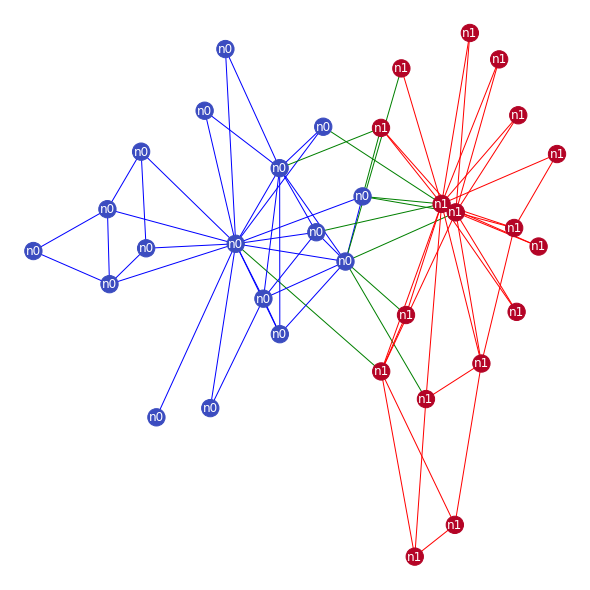

In [16]:
edge_color = {}
for edge in G.edges():
  n1, n2 = edge
  edge_color[edge] = community_map[n1] if community_map[n1] == community_map[n2] else 2
  if community_map[n1] == community_map[n2] and community_map[n1] == 0:
    edge_color[edge] = 'blue'
  elif community_map[n1] == community_map[n2] and community_map[n1] == 1:
    edge_color[edge] = 'red'
  else:
    edge_color[edge] = 'green'

G_orig = copy.deepcopy(G)
nx.classes.function.set_edge_attributes(G, edge_color, name='color')
colors = nx.get_edge_attributes(G,'color').values()
labels = nx.get_node_attributes(G, 'node_type')
plt.figure(figsize=(8, 8))
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color, edge_color=colors, labels=labels, font_color='white')
show()

which include edges within each clubs (2 types) and edges across two clubs (1 type). Different types of nodes and edges are visualized in different colors. The NetworkX object `G` in following code can be transformed into `deepsnap.hetero_graph.HeteroGraph` directly.  
其中包括每个球杆内的边缘（2 种类型）和两个球杆之间的边缘（1 种类型）。 不同类型的节点和边以不同的颜色可视化。 下面代码中的NetworkX对象G可以直接转化为deepsnap.hetero_graph.HeteroGraph。

## Transforming to DeepSNAP representation  
转换为 DeepSNAP 表示

The NetworkX object `G` in following code can be transformed into `deepsnap.hetero_graph.HeteroGraph` directly!  
下面代码中的NetworkX对象G可以直接转化为deepsnap.hetero_graph.HeteroGraph！

In [17]:
from deepsnap.hetero_graph import HeteroGraph

hete = HeteroGraph(G_orig)

## Question 1.3: How many nodes are of each type (10 Points)  
问题 1.3：每种类型有多少个节点（10 分）

Submit your answers on Gradescope.  
在 Gradescope 上提交您的答案。


In [18]:
#PRW
print(hete.node_type)
print(len(hete.node_type['n0']))
#由于之前的失误，我发现如果是0-1这种数字的话，value就是tensor

{'n0': ['n0', 'n0', 'n0', 'n0', 'n0', 'n0', 'n0', 'n0', 'n0', 'n0', 'n0', 'n0', 'n0', 'n0', 'n0', 'n0', 'n0'], 'n1': ['n1', 'n1', 'n1', 'n1', 'n1', 'n1', 'n1', 'n1', 'n1', 'n1', 'n1', 'n1', 'n1', 'n1', 'n1', 'n1', 'n1']}
17


In [19]:
def get_nodes_per_type(hete):
  # TODO: Implement this function that takes a DeepSNAP dataset object
  # and return the number of nodes per `node_type`.

  num_nodes_n0 = 0
  num_nodes_n1 = 0

  ############# Your code here ############
  ## (~2 line of code)
  ## Note
  ## 1. Colab autocomplete functionality might be useful.
  num_nodes_n0 = hete.num_nodes('n0')
  num_nodes_n1 = hete.num_nodes('n1')

  #########################################

  return num_nodes_n0, num_nodes_n1

num_nodes_n0, num_nodes_n1 = get_nodes_per_type(hete)
print("Node type n0 has {} nodes".format(num_nodes_n0))
print("Node type n1 has {} nodes".format(num_nodes_n1))

Node type n0 has 17 nodes
Node type n1 has 17 nodes


## Question 1.4: Message Types: How many edges are of each message type (10 Points)  
问题 1.4：消息类型：每种消息类型有多少条边（10 分）

Submit your answers on Gradescope.

When working with heterogenous graphs, as we have discussed before, we now work with heterogenous message types (i.e. different message types for `node_type` and `edge_type` combinations). For example, an edge of type `e0` connecting two nodes in club "Mr. HI" would have a message type of (`n0`, `e0`, `n0`). In this problem we will analyze how many edges in our graph are of each message type.  
在处理异构图时，正如我们之前讨论过的，我们现在处理异构消息类型（即 node_type 和 edge_type 组合的不同消息类型）。 例如，连接俱乐部“Mr. HI”中的两个节点的类型 e0 的边将具有 (n0, e0, n0) 的消息类型。 在这个问题中，我们将分析图中有多少条边属于每种消息类型。

**Hint**: If you want to learn more about what the different message types are try the call `hete.message_types`  
提示：如果您想了解有关不同消息类型的更多信息，请尝试调用 hete.message_types

In [20]:
#PRW
hete.message_types

[('n0', 'e0', 'n0'), ('n0', 'e2', 'n1'), ('n1', 'e1', 'n1')]

In [21]:
def get_num_message_edges(hete):
  # TODO: Implement this function that takes a DeepSNAP dataset object
  # and return the number of edges for each message type. 
  # You should return a list of tuples as 
  # (message_type, num_edge)

  message_type_edges = []

  ############# Your code here ############
  ## (~2 line of code)
  ## Note
  ## 1. Colab autocomplete functionality might be useful.
  for message_type in hete.message_types:
      message_type_edges.append([message_type, hete.num_edges(message_type=message_type)])

  #########################################

  return message_type_edges

message_type_edges = get_num_message_edges(hete)
for (message_type, num_edges) in message_type_edges:
  print("Message type {} has {} edges".format(message_type, num_edges))


Message type ('n0', 'e0', 'n0') has 35 edges
Message type ('n0', 'e2', 'n1') has 11 edges
Message type ('n1', 'e1', 'n1') has 32 edges


## Question 1.5: Dataset Splitting: How many nodes in each dataset split? (10 Points)  
问题 1.5：数据集拆分：每个数据集拆分多少个节点？ （10分）

Submit your answers on Gradescope.

DeepSNAP has built in Dataset creation and splitting methods for heterogeneous graphs. Here we will create train, validation, and test datasets for a node prediction task and inspect the resulting subgraphs. Specifically, write a function that computes the number of nodes in each dataset split.  
DeepSNAP 内置了异构图的数据集创建和拆分方法。 在这里，我们将为节点预测任务创建训练、验证和测试数据集，并检查生成的子图。 具体来说，编写一个函数来计算每个数据集拆分中的节点数。


In [22]:
from deepsnap.dataset import GraphDataset

def compute_dataset_split_counts(datasets):
  # TODO: Implement this function that takes a dict of datasets
  # and returns a dict mapping dataset names to the number of labeled
  # nodes used for supervision in that respective dataset.  
  
  data_set_splits = {}

  ############# Your code here ############
  ## (~3 line of code)
  ## Note
  ## 1. DeepSNAP `node_label_index` will be helpful.
  ## 2. Remember to count both node_types
  for dataset_name, dataset in datasets.items():
    data_set_splits[dataset_name] = 0
    print(dataset[0].node_label_index)
    for k, v in dataset[0].node_label_index.items():
      data_set_splits[dataset_name] += v.shape[0]
  '''
  for ds_name,ds in datasets.items():
    #data_set_splits[ds_name]=ds[0].sha
    #print(ds_name)  train
    #print(ds[0].node_label_index)  {'n0': tensor([10,  8,  3, 12,  0, 13]), 'n1': tensor([ 0,  8,  1, 15,  5,  7])}
    data_set_splits[ds_name]=ds[0].node_label_index['n0'].shape[0]+ds[0].node_label_index['n1'].shape[0]
  '''
  #########################################

  return data_set_splits


dataset = GraphDataset([hete], task='node')
# Splitting the dataset
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.4, 0.3, 0.3])
datasets = {'train': dataset_train, 'val': dataset_val, 'test': dataset_test}

data_set_splits = compute_dataset_split_counts(datasets)
for dataset_name, num_nodes in data_set_splits.items():
  print("{} dataset has {} nodes".format(dataset_name, num_nodes))

{'n0': tensor([ 4,  8, 13,  5, 10, 15]), 'n1': tensor([12,  3, 10,  6, 16, 13])}
{'n0': tensor([14,  2, 11,  9,  7]), 'n1': tensor([1, 9, 4, 7, 5])}
{'n0': tensor([16,  0,  6,  1,  3, 12]), 'n1': tensor([ 0,  8, 14, 11,  2, 15])}
train dataset has 12 nodes
val dataset has 10 nodes
test dataset has 12 nodes


## DeepSNAP Dataset Visualization

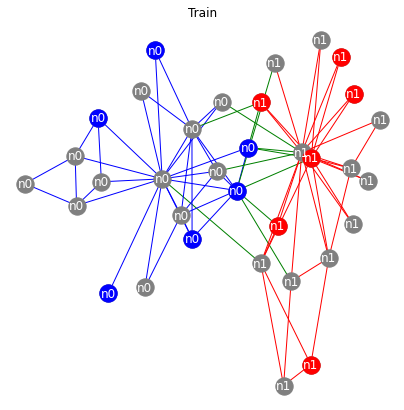

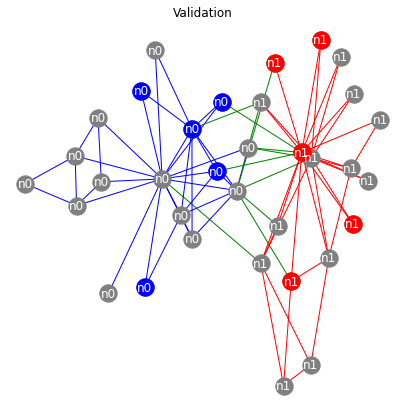

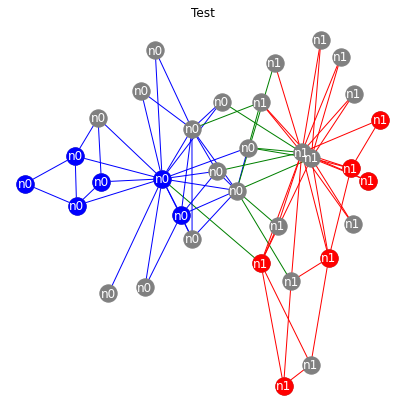

In [23]:
from deepsnap.dataset import GraphDataset

dataset = GraphDataset([hete], task='node')
# Splitting the dataset
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.4, 0.3, 0.3])
titles = ['Train', 'Validation', 'Test']

for i, dataset in enumerate([dataset_train, dataset_val, dataset_test]):
  n0 = hete._convert_to_graph_index(dataset[0].node_label_index['n0'], 'n0').tolist()
  n1 = hete._convert_to_graph_index(dataset[0].node_label_index['n1'], 'n1').tolist()

  plt.figure(figsize=(7, 7))
  plt.title(titles[i])
  nx.draw(G_orig, pos=pos, node_color="grey", edge_color=colors, labels=labels, font_color='white')
  nx.draw_networkx_nodes(G_orig.subgraph(n0), pos=pos, node_color="blue")
  nx.draw_networkx_nodes(G_orig.subgraph(n1), pos=pos, node_color="red")
  show()

# 2 Heterogeneous Graph Node Property Prediction  
异构图节点属性预测

In this part we will use PyTorch Geometric and DeepSNAP to implement a GNN model for heterogeneous graph node property prediction (node classification). This part of Colab requires you having good understandings on the heterogeneous graph and how to implement the GNN layers by using PyG.  
在这一部分，我们将使用 PyTorch Geometric 和 DeepSNAP 来实现一个用于异构图节点属性预测（节点分类）的 GNN 模型。 Colab 的这部分要求您对异构图以及如何使用 PyG 实现 GNN 层有很好的理解。

At first let's take look at the general structure of a heterogeneous layer by an example.  
首先让我们通过一个例子来看看异构层的一般结构。

Let's assume we have a graph $G$, which contains two node types $a$ and $b$, and three message types $m_1=(a, r_1, a)$, $m_2=(a, r_2, b)$ and $m_3=(a, r_3, b)$.  
假设我们有一个图 G ，其中包含两个节点类型 a 和 b ，以及三个消息类型 m1=(a,r1,a) 、 m2=(a,r2,b) 和 m3=(a,r3,b) .

Thus, for $G$ a heterogeneous layer will contains three Heterogeneous GNN layers (`HeteroGNNConv` in this Colab) where each `HeteroGNNConv` layer will perform the message passing and aggregation with respect to only one message type. The overview of the heterogeneous layer is shown below:  
因此，对于 G，异构层将包含三个异构 GNN 层（本 Colab 中的 HeteroGNNConv），其中每个 HeteroGNNConv 层将仅针对一种消息类型执行消息传递和聚合。 异构层的概述如下所示：

<br/>
<center>
<img src="https://web.stanford.edu/class/cs224w/images/colab4/hetero_conv.png"/>
</center>
<br/>

In this Colab, all the $l^{th}$ Heterogeneous GNN layers will be managed by a ($l^{th}$) Heterogeneous GNN Wrapper layer (the `HeteroGNNWrapperConv`). The $l^{th}$ Heterogeneous GNN Wrapper layer will take in the input node embeddings from $(l-1)^{th}$ layer and aggregate (across message types) the Heterogeneous GNN layers' results. For example, the wrapper layer will aggregate node type $b$'s node embeddings from Heterogeneous GNN layers for $m_2$ and $m_3$. The "simplified" heterogeneous layer structure is shown below:  
在这个 Colab 中，所有 lth Heterogeneous GNN 层都将由 (lth) Heterogeneous GNN Wrapper 层（HeteroGNNWrapperConv）管理。 第 l 个异构 GNN 包装层将接收来自第 (l-1) 层的输入节点嵌入并聚合（跨消息类型）异构 GNN 层的结果。 例如，包装层将从异构 GNN 层为 m2 和 m3 聚合节点类型 b 的节点嵌入。 “简化”的异构层结构如下图所示：

<br/>
<center>
<img src="http://web.stanford.edu/class/cs224w/images/colab4/hetero_conv_1.png"/>
</center>
<br/>

<font color='red'>We recommend you implement the heterogeneous GNN model in following steps:</font>  
我们建议您按以下步骤实施异构 GNN 模型：

1. Implement the `HeteroGNNConv` first.  
首先实现 HeteroGNNConv。
2. Implement the `mean` aggregation in `HeteroGNNWrapperConv`.  
在 HeteroGNNWrapperConv 中实现均值聚合。
3. Implement the `generate_convs`.  
实现 generate_convs。
4. Implement the `HeteroGNN` model and the `train` function.  
实现 HeteroGNN 模型和训练函数。
5. Train the model with `mean` aggregation across the message types and make sure your model has reasonable performance.  
使用跨消息类型的平均聚合训练模型，并确保您的模型具有合理的性能。
6. Implement the `attn` aggregation in `HeteroGNNWrapperConv`.  
在 HeteroGNNWrapperConv 中实现 attn 聚合。
7. Train the model with `attn` aggregation across the message types and make sure your model has reasonable performance.  
使用跨消息类型的 attn 聚合训练模型，并确保您的模型具有合理的性能。

## Setup

In [24]:
import copy
import torch
import deepsnap
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn

from sklearn.metrics import f1_score
from deepsnap.hetero_gnn import forward_op
from deepsnap.hetero_graph import HeteroGraph
from torch_sparse import SparseTensor, matmul

## Dataset

You need to login to your Google account and enter the verification code below.  
您需要登录您的 Google 帐户并输入下面的验证码。

In [25]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [26]:
id='1ivlxd6lJMcZ9taS44TMGG72x2V1GeVvk'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('acm.pkl')

## Heterogeneous GNN Layer

Now let's start working on our own implementation of a heterogeneous layer (the `HeteroGNNConv`)! Similar to what we did in Colab 3, we will implement the layer using PyTorch Geometric. In general, our heterogeneous GNN layer draws ideas from the **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)).  
现在让我们开始研究我们自己的异构层（HeteroGNNConv）的实现！ 与我们在 Colab 3 中所做的类似，我们将使用 PyTorch Geometric 实现该层。 一般来说，我们的异构 GNN 层从 GraphSAGE（Hamilton 等人（2017））中汲取了想法。

At first, let's implement the GNN layer for each message type :  
首先，让我们为每种消息类型实现 GNN 层：

\begin{equation}
m =(s, r, d)
\end{equation}

Each message type is a tuple containing three elements where $s$ refers to the source node type, $r$ refers to the edge (relation) type and $d$ refers to the destination node type. The update rule is very similar to that of GraphSAGE but we need to include the node types and the edge type. The update rule is described as below:  
每个消息类型都是一个包含三个元素的元组，其中 $s$ 指的是源节点类型，$r$ 指的是边（关系）类型，$d$ 指的是目标节点类型。 更新规则与 GraphSAGE 非常相似，但我们需要包括节点类型和边类型。 更新规则描述如下：

\begin{equation}
h_v^{(l)[m]} = W^{(l)[m]} \cdot \text{CONCAT} \Big( W_d^{(l)[m]} \cdot h_v^{(l-1)}, W_s^{(l)[m]} \cdot AGG(\{h_u^{(l-1)}, \forall u \in N_{m}(v) \})\Big)
\end{equation}

where $[m]$ indicates that the weight matrices or embeddings with respect to message type $m$, $W_s^{(l)[m]}$ computes the messages from neighboring nodes, $W_d^{(l)[m]}$ compute messages from the node itself, and $W^{(l)[m]}$ aggregates messages from both node types. In the equation above, $v$ has the node type $d$, and $u$ has the node type $s$.  
其中 $[m]$ 表示相对于消息类型 $m$ 的权重矩阵或嵌入，$W_s^{(l)[m]}$ 计算来自相邻节点的消息，$W_d^{(l)[m ]}$ 计算来自节点本身的消息，$W^{(l)[m]}$ 聚合来自两种节点类型的消息。 在上面的等式中，$v$ 的节点类型为 $d$，而 $u$ 的节点类型为 $s$。

For simplicity, we use mean aggregations for $AGG$ where:  
为简单起见，我们对 $AGG$ 使用均值聚合，其中：

\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N_{m}(v) \}) = \frac{1}{|N_{m}(v)|} \sum_{u\in N_{m}(v)} h_u^{(l-1)}
\end{equation}

In [27]:
class HeteroGNNConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels_src, in_channels_dst, out_channels):
        super(HeteroGNNConv, self).__init__(aggr="mean")

        self.in_channels_src = in_channels_src
        self.in_channels_dst = in_channels_dst
        self.out_channels = out_channels

        # To simplify implementation, please initialize both self.lin_dst
        # and self.lin_src out_features to out_channels
        self.lin_dst = None
        self.lin_src = None

        self.lin_update = None

        ############# Your code here #############
        ## (~3 lines of code)
        self.lin_dst=nn.Linear(self.in_channels_dst,self.out_channels)  #concat左
        self.lin_src=nn.Linear(self.in_channels_src,self.out_channels)  #concat右
        self.lin_update=nn.Linear(self.out_channels*2,self.out_channels)  #𝑊(𝑙)[𝑚]

        ##########################################

    def forward(
        self,
        node_feature_src,
        node_feature_dst,
        edge_index,
        size=None,
        res_n_id=None,
    ):
        ############# Your code here #############
        ## (~1 line of code)
        return self.propagate(edge_index, size=size,
                              node_feature_src=node_feature_src,
                              node_feature_dst=node_feature_dst,
                              res_n_id=res_n_id)

        ##########################################

    def message_and_aggregate(self, edge_index, node_feature_src):

        ############# Your code here #############
        ## (~1 line of code)
        ## Note:
        ## 1. Different from what we implemented in Colab 3, we use message_and_aggregate
        ## to replace the message and aggregate. The benefit is that we can avoid
        ## materializing x_i and x_j, and make the implementation more efficient.
        ## 2. To implement efficiently, following PyG documentation is helpful:
        ## https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
        ## 3. Here edge_index is torch_sparse SparseTensor.
        out=matmul(edge_index,node_feature_src,reduce=self.aggr)  #adj_t,x,reduce='mean'   matmul张量相乘
        '''
        #out = torch_scatter.scatter(node_feature_src, edge_index, reduce='mean')
        adj_t = edge_index
        x = node_feature_src
        return matmul(adj_t, x, reduce=self.aggr)
        '''
        ##########################################

        return out

    def update(self, aggr_out, node_feature_dst, res_n_id):

        ############# Your code here #############
        ## (~4 lines of code)
        aggr_out = self.lin_src(aggr_out)
        node_feature_dst = self.lin_dst(node_feature_dst)
        
        aggr_out = torch.cat([aggr_out, node_feature_dst], dim=-1)
        aggr_out = self.lin_update(aggr_out)

        ##########################################

        return aggr_out

In [28]:
#PRW
x1=torch.randn(7, 34)
x2=torch.randn(7, 34)
x3=torch.cat((x1,x2),dim=-1)
x3.shape

torch.Size([7, 68])

## Heterogeneous GNN Wrapper Layer
异构 GNN 包装层

After implementing the GNN layer for each message type, we need to somehow aggregate the the node embedding results (with respect to each message types) together. Here we will implement two types of message type level aggregation.  
在为每种消息类型实现 GNN 层之后，我们需要以某种方式将节点嵌入结果（关于每种消息类型）聚合在一起。 这里我们将实现两种消息类型级别的聚合。

The first one is simply the mean aggregation:  
第一个只是平均聚合：

\begin{equation}
h_v^{(l)} = \frac{1}{M}\sum_{m=1}^{M}h_v^{(l)[m]}
\end{equation}

Here node $v$ has the node type $d$ and $M$ is the total number of message types that the destination node type is $d$.  
这里节点 $v$ 具有节点类型 $d$，$M$ 是目标节点类型为 $d$ 的消息类型总数。

The other one is the semantic level attention introduced in **HAN** ([Wang et al. (2019)](https://arxiv.org/abs/1903.07293)). Instead of directly averaging on the message type aggregation results, we use attention to learn which message type result can be more important, then aggregate from all the message types. Following are the equations for semantic level attention:  
另一个是HAN中引入的语义级注意力（Wang et al. (2019)）。 我们不是直接对消息类型聚合结果进行平均，而是使用注意力来了解哪种消息类型结果可能更重要，然后从所有消息类型中进行聚合。 以下是语义级注意力的方程式：

\begin{equation}
e_{m} = \frac{1}{|V_{d}|} \sum_{v \in V_{d}} q_{attn}^T \cdot tanh \Big( W_{attn}^{(l)} \cdot h_v^{(l)[m]} + b \Big)
\end{equation}

where $m$ refers to message type and $d$ refers to the destination node type. Then we can compute the attention and update the $h_v^{(l)}$:  
其中 m 指的是消息类型，d 指的是目标节点类型。 然后我们可以计算注意力并更新 h(l)v ：

\begin{equation}
\alpha_{m} = \frac{\exp(e_{m})}{\sum_{m=1}^M \exp(e_{m})}
\end{equation}

\begin{equation}
h_v^{(l)} = \sum_{m=1}^{M} \alpha_{m} \cdot h_v^{(l)[m]}
\end{equation}

In [29]:
class HeteroGNNWrapperConv(deepsnap.hetero_gnn.HeteroConv):
    def __init__(self, convs, args, aggr="mean"):
        super(HeteroGNNWrapperConv, self).__init__(convs, None)
        self.aggr = aggr

        # Map the index and message type
        self.mapping = {}

        # A numpy array that stores the final attention probability
        self.alpha = None

        self.attn_proj = None

        if self.aggr == "attn":
            ############# Your code here #############
            ## (~1 line of code)
            ## Note:
            ## 1. Initialize self.attn_proj here.
            ## 2. You should use nn.Sequential for self.attn_proj
            ## 3. nn.Linear and nn.Tanh are useful.
            ## 4. You can create a vector parameter by using:
            ## nn.Linear(some_size, 1, bias=False)
            ## 5. The first linear layer should have out_features as args['attn_size']
            ## 6. You can assume we only have one "head" for the attention.
            ## 7. We recommend you to implement the mean aggregation first. After 
            ## the mean aggregation works well in the training, then you can 
            ## implement this part.
            self.attn_proj = nn.Sequential(
                nn.Linear(args['hidden_size'], args['attn_size']),  #Wh+b
                nn.Tanh(),
                nn.Linear(args['attn_size'], 1, bias=False), # q_semantic_attention
            )
            '''
            self.attn_proj = nn.Sequential(
                nn.Linear(args['hidden_size'], args['attn_size'], bias=True),
                nn.Tanh(),
                nn.Linear(args['attn_size'], 1)
            )
            '''
            ##########################################
    
    def reset_parameters(self):
        super(HeteroConvWrapper, self).reset_parameters()
        if self.aggr == "attn":
            for layer in self.attn_proj.children():
                layer.reset_parameters()
    
    def forward(self, node_features, edge_indices):
        message_type_emb = {}
        for message_key, message_type in edge_indices.items():
            src_type, edge_type, dst_type = message_key
            node_feature_src = node_features[src_type]
            node_feature_dst = node_features[dst_type]
            edge_index = edge_indices[message_key]
            message_type_emb[message_key] = (
                self.convs[message_key](
                    node_feature_src,
                    node_feature_dst,
                    edge_index,
                )
            )
        node_emb = {dst: [] for _, _, dst in message_type_emb.keys()}
        mapping = {}        
        for (src, edge_type, dst), item in message_type_emb.items():
            mapping[len(node_emb[dst])] = (src, edge_type, dst)
            node_emb[dst].append(item)
        self.mapping = mapping
        for node_type, embs in node_emb.items():
            if len(embs) == 1:
                node_emb[node_type] = embs[0]
            else:
                node_emb[node_type] = self.aggregate(embs)
        return node_emb
    
    def aggregate(self, xs):
        # TODO: Implement this function that aggregates all message type results.
        # Here, xs is a list of tensors (embeddings) with respect to message 
        # type aggregation results.

        if self.aggr == "mean":

            ############# Your code here #############
            ## (~2 lines of code)
            x = torch.stack(xs, dim=-1)
            return x.mean(dim=-1)

            ##########################################

        elif self.aggr == "attn":

            ############# Your code here #############
            ## (~10 lines of code)
            ## Note:
            ## 1. Store the value of attention alpha (as a numpy array) to self.alpha,
            ## which has the shape (len(xs), ) self.alpha will be not be used 
            ## to backpropagate etc. in the model. We will use it to see how much 
            ## attention the layer pays on different message types.
            ## 2. torch.softmax and torch.cat are useful.
            ## 3. You might need to reshape the tensors by using the 
            ## `view()` function https://pytorch.org/docs/stable/tensor_view.html
            # xs[0].shape [N, hidden_size]
            x = torch.stack(xs, dim=0)
            # x.shape [# msg type, N, hidden_size]
            self.alpha = []

            ret = self.attn_proj(x)
            assert ret.shape[-1] == 1
            ret = ret.view((ret.shape[0], ret.shape[1]))
            # ret.shape [# msg type, N]
            ret = torch.mean(ret, dim=-1)
            print(ret.shape)
            alpha = torch.softmax(ret, dim=0)
            print(alpha)
            # [# msg type, 1]
            self.alpha = alpha.detach().cpu().numpy()


            return (x * alpha[..., None, None].detach()).sum(dim=0)
            # return shape: [N, hidden_size]
            '''
            N = xs[0].shape[0] # Number of nodes for that node type
            M = len(xs) # Number of message types for that node type

            x = torch.cat(xs, dim=0).view(M, N, -1) # M * N * D
            z = self.attn_proj(x).view(M, N) # M * N * 1
            z = z.mean(1) # M * 1
            alpha = torch.softmax(z, dim=0) # M * 1

            # Store the attention result to self.alpha as np array
            self.alpha = alpha.view(-1).data.cpu().numpy()
  
            alpha = alpha.view(M, 1, 1)
            x = x * alpha
            return x.sum(dim=0)
            #答案写法：x = self.attn_proj(torch.stack(xs, dim=0))
            #x = torch.mean(x, dim=1)

            #self.alpha = torch.softmax(x, dim=0)
            #self.alpha = self.alpha.detach()

            #out = torch.stack(xs, dim=0)
            #out = self.alpha.unsqueeze(-1) * out

            #out = torch.sum(out, dim=0)
            #return out
            '''
            ##########################################

## Initialize Heterogeneous GNN Layers  
初始化异构 GNN 层

Now let's initialize the Heterogeneous GNN Layers. Different from homogeneous graph case, heterogeneous case can be a little bit complex.  
现在让我们初始化异构 GNN 层。 与同构图案例不同，异构案例可能有点复杂。

In general, we need to create a dictionary of `HeteroGNNConv` layers where the keys are message types.  
一般来说，我们需要创建一个 HeteroGNNConv 层的字典，其中键是消息类型。

* To get all message types, `deepsnap.hetero_graph.HeteroGraph.message_types` is useful.  
要获取所有消息类型， deepsnap.hetero_graph.HeteroGraph.message_types 很有用。
* If we are initializing the first conv layers, we need to get the feature dimension of each node type. Using `deepsnap.hetero_graph.HeteroGraph.num_node_features(node_type)` will return the node feature dimension of `node_type`. In this function, we will set each `HeteroGNNConv` `out_channels` to be `hidden_size`.  
如果我们正在初始化第一个 conv 层，我们需要获取每个节点类型的特征维度。 使用 deepsnap.hetero_graph.HeteroGraph.num_node_features(node_type) 将返回 node_type 的节点特征维度。 在这个函数中，我们将每个 HeteroGNNConv out_channels 设置为 hidden_size。
* If we are not initializing the first conv layers, all node types will have the same embedding dimension `hidden_size` and we still set `HeteroGNNConv` `out_channels` to be `hidden_size` for simplicity.  
如果我们不初始化第一个 conv 层，所有节点类型将具有相同的嵌入维度 hidden_size，为了简单起见，我们仍然将 HeteroGNNConv out_channels 设置为 hidden_size。



In [31]:
#PRW
print(type(hete))
#hete.num_node_features()  #会报错。应该是因为feature是list而不是tensor？

<class 'deepsnap.hetero_graph.HeteroGraph'>


In [32]:
def generate_convs(hetero_graph, conv, hidden_size, first_layer=False):
    # TODO: Implement this function that returns a dictionary of `HeteroGNNConv` 
    # layers where the keys are message types. `hetero_graph` is deepsnap `HeteroGraph`
    # object and the `conv` is the `HeteroGNNConv`.

    convs = {}

    ############# Your code here #############
    ## (~9 lines of code)
    if first_layer:
      for message_type in hetero_graph.message_types:
        node_type_0 = message_type[0]
        node_type_2 = message_type[2]
        feat_dim_0 = hetero_graph.num_node_features(node_type_0)
        feat_dim_2 = hetero_graph.num_node_features(node_type_2)
        print(node_type_0, node_type_2, feat_dim_0, feat_dim_2)
        convs[message_type] = conv(feat_dim_0, feat_dim_2, hidden_size)
    else:
      for message_type in hetero_graph.message_types:
        convs[message_type] = conv(hidden_size, hidden_size, hidden_size)
    '''
        for message_type in hetero_graph.message_types:
        if first_layer is True:
            src_type = message_type[0]
            dst_type = message_type[2]
            src_size = hetero_graph.num_node_features(src_type)
            dst_size = hetero_graph.num_node_features(dst_type)
            convs[message_type] = conv(src_size,dst_size, hidden_size)
        else:
            convs[message_type] = conv(hidden_size, hidden_size, hidden_size)  
    '''
    ##########################################
    print(convs)
    return convs

## HeteroGNN  
异质神经网络

Now we will make a simple HeteroGNN model which contains only two `HeteroGNNWrapperConv` layers.  
现在我们将制作一个简单的 HeteroGNN 模型，它只包含两个 HeteroGNNWrapperConv 层。

For the forward function in `HeteroGNN`, the model is going to be run as following:  
对于 HeteroGNN 中的前向函数，模型将按如下方式运行：

$\text{self.convs1} \rightarrow \text{self.bns1} \rightarrow \text{self.relus1} \rightarrow \text{self.convs2} \rightarrow \text{self.bns2} \rightarrow \text{self.relus2} \rightarrow \text{self.post_mps}$

In [33]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, hetero_graph, args, aggr="mean"):
        super(HeteroGNN, self).__init__()

        self.aggr = aggr
        self.hidden_size = args['hidden_size']

        self.convs1 = None
        self.convs2 = None

        self.bns1 = nn.ModuleDict()
        self.bns2 = nn.ModuleDict()
        self.relus1 = nn.ModuleDict()
        self.relus2 = nn.ModuleDict()
        self.post_mps = nn.ModuleDict()

        ############# Your code here #############
        ## (~10 lines of code)
        ## Note:
        ## 1. For self.convs1 and self.convs2, call generate_convs at first and then
        ## pass the returned dictionary of `HeteroGNNConv` to `HeteroGNNWrapperConv`.
        ## 2. For self.bns, self.relus and self.post_mps, the keys are node_types.
        ## `deepsnap.hetero_graph.HeteroGraph.node_types` will be helpful.
        ## 3. Initialize all batchnorms to torch.nn.BatchNorm1d(hidden_size, eps=1.0).
        ## 4. Initialize all relus to nn.LeakyReLU().
        ## 5. For self.post_mps, each value in the ModuleDict is a linear layer 
        ## where the `out_features` is the number of classes for that node type.
        ## `deepsnap.hetero_graph.HeteroGraph.num_node_labels(node_type)` will be
        ## useful.
        convs1 = generate_convs(hetero_graph, HeteroGNNConv, self.hidden_size, first_layer=True)
        convs2 = generate_convs(hetero_graph, HeteroGNNConv, self.hidden_size)

        self.convs1 = HeteroGNNWrapperConv(convs1, args, aggr=self.aggr)
        self.convs2 = HeteroGNNWrapperConv(convs2, args, aggr=self.aggr)

        for node_type in hetero_graph.node_types:
            self.bns1[node_type] = torch.nn.BatchNorm1d(self.hidden_size, eps=1)
            self.bns2[node_type] = torch.nn.BatchNorm1d(self.hidden_size, eps=1)
            self.relus1[node_type] = nn.LeakyReLU()
            self.relus2[node_type] = nn.LeakyReLU()
            self.post_mps[node_type] = nn.Linear(self.hidden_size, hetero_graph.num_node_labels(node_type))

        ##########################################

    def forward(self, node_feature, edge_index):
        # TODO: Implement the forward function. Notice that `node_feature` is 
        # a dictionary of tensors where keys are node types and values are 
        # corresponding feature tensors. The `edge_index` is a dictionary of 
        # tensors where keys are message types and values are corresponding
        # edge index tensors (with respect to each message type).

        x = node_feature

        ############# Your code here #############
        ## (~7 lines of code)
        ## Note:
        ## 1. `deepsnap.hetero_gnn.forward_op` can be helpful.
        x = self.convs1(x, edge_index)
        x = forward_op(x, self.bns1)
        x = forward_op(x, self.relus1)
        x = self.convs2(x, edge_index)
        x = forward_op(x, self.bns2)
        x = forward_op(x, self.relus2)
        x = forward_op(x, self.post_mps)

        ##########################################
        
        return x

    def loss(self, preds, y, indices):
        
        loss = 0
        loss_func = F.cross_entropy

        ############# Your code here #############
        ## (~3 lines of code)
        ## Note:
        ## 1. For each node type in preds, accumulate computed loss to `loss`
        ## 2. Loss need to be computed with respect to the given index
        print(preds['paper'].shape, indices['paper'].shape, y['paper'].shape)
        for key in preds.keys():
          indice = indices[key]
          loss += loss_func(preds[key][indice], y[key][indice])
        '''
        for node_type in preds:
            idx = indices[node_type]
            loss += loss_func(preds[node_type][idx], y[node_type][idx])
        '''
        ##########################################

        return loss

## Training and Testing

Here we provide you with the functions to train and test. You only need to implement one line of code here.  
在这里，我们为您提供了训练和测试的功能。 这里只需要实现一行代码即可。

**Please do not modify other parts in `train` and `test` for grading purposes.**请不要在火车和测试中修改其他部件以进行评分。

In [35]:
def train(model, optimizer, hetero_graph, train_idx):
    model.train()
    optimizer.zero_grad()
    preds = model(hetero_graph.node_feature, hetero_graph.edge_index)

    loss = None

    ############# Your code here #############
    ## Note:
    ## 1. `deepsnap.hetero_graph.HeteroGraph.node_label` is useful
    ## 2. Compute the loss here
    loss = model.loss(preds, hetero_graph.node_label, train_idx)

    ##########################################

    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, graph, indices, best_model=None, best_val=0):
    model.eval()
    accs = []
    for index in indices:
        preds = model(graph.node_feature, graph.edge_index)
        num_node_types = 0
        micro = 0
        macro = 0
        for node_type in preds:
            idx = index[node_type]
            pred = preds[node_type][idx]
            pred = pred.max(1)[1]
            label_np = graph.node_label[node_type][idx].cpu().numpy()
            pred_np = pred.cpu().numpy()
            micro = f1_score(label_np, pred_np, average='micro')
            macro = f1_score(label_np, pred_np, average='macro')
            num_node_types += 1
        # Averaging f1 score might not make sense, but in our example we only
        # have one node type
        micro /= num_node_types
        macro /= num_node_types
        accs.append((micro, macro))
    if accs[1][0] > best_val:
        best_val = accs[1][0]
        best_model = copy.deepcopy(model)
    return accs, best_model, best_val

In [36]:
# Please do not change the following parameters
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'hidden_size': 64,
    'epochs': 100,
    'weight_decay': 1e-5,
    'lr': 0.003,
    'attn_size': 32,
}

## Dataset and Preprocessing

In the next, we will load the data and create a tensor backend (without a NetworkX graph) `deepsnap.hetero_graph.HeteroGraph` object.  
接下来，我们将加载数据并创建一个张量后端（没有 NetworkX 图） deepsnap.hetero_graph.HeteroGraph 对象。

We will use the `ACM(3025)` dataset in our node property prediction task, which is proposed in **HAN** ([Wang et al. (2019)](https://arxiv.org/abs/1903.07293)) and our dataset is extracted from [DGL](https://www.dgl.ai/)'s [ACM.mat](https://data.dgl.ai/dataset/ACM.mat).  
我们将在我们的节点属性预测任务中使用 ACM(3025) 数据集，该数据集是在 HAN (Wang et al. (2019)) 中提出的，我们的数据集是从 DGL 的 ACM.mat 中提取的。

The original ACM dataset has three node types and two edge (relation) types. For simplicity, we simplify the heterogeneous graph to one node type and two edge types (shown below). This means that in our heterogeneous graph, we have one node type (paper) and two message types (paper, author, paper) and (paper, subject, paper).  
原始 ACM 数据集具有三种节点类型和两种边（关系）类型。 为简单起见，我们将异构图简化为一种节点类型和两种边类型（如下所示）。 这意味着在我们的异构图中，我们有一种节点类型（论文）和两种消息类型（论文、作者、论文）和（论文、主题、论文）。

<br/>
<center>
<img src="http://web.stanford.edu/class/cs224w/images/colab4/cs224w-acm.png"/>
</center>

In [37]:
print("Device: {}".format(args['device']))

# Load the data
data = torch.load("acm.pkl")

# Message types
message_type_1 = ("paper", "author", "paper")
message_type_2 = ("paper", "subject", "paper")

# Dictionary of edge indices
edge_index = {}
edge_index[message_type_1] = data['pap']
edge_index[message_type_2] = data['psp']

# Dictionary of node features
node_feature = {}
node_feature["paper"] = data['feature']

# Dictionary of node labels
node_label = {}
node_label["paper"] = data['label']

# Load the train, validation and test indices
train_idx = {"paper": data['train_idx'].to(args['device'])}
val_idx = {"paper": data['val_idx'].to(args['device'])}
test_idx = {"paper": data['test_idx'].to(args['device'])}

# Construct a deepsnap tensor backend HeteroGraph
hetero_graph = HeteroGraph(
    node_feature=node_feature,
    node_label=node_label,
    edge_index=edge_index,
    directed=True
)

print(f"ACM heterogeneous graph: {hetero_graph.num_nodes()} nodes, {hetero_graph.num_edges()} edges")

# Node feature and node label to device
for key in hetero_graph.node_feature:
    hetero_graph.node_feature[key] = hetero_graph.node_feature[key].to(args['device'])
for key in hetero_graph.node_label:
    hetero_graph.node_label[key] = hetero_graph.node_label[key].to(args['device'])

# Edge_index to sparse tensor and to device
for key in hetero_graph.edge_index:
    edge_index = hetero_graph.edge_index[key]
    adj = SparseTensor(row=edge_index[0], col=edge_index[1], sparse_sizes=(hetero_graph.num_nodes('paper'), hetero_graph.num_nodes('paper')))
    hetero_graph.edge_index[key] = adj.t().to(args['device'])
print(hetero_graph.edge_index[message_type_1])
print(hetero_graph.edge_index[message_type_2])

Device: cuda
ACM heterogeneous graph: {'paper': 3025} nodes, {('paper', 'author', 'paper'): 26256, ('paper', 'subject', 'paper'): 2207736} edges
SparseTensor(row=tensor([   0,    0,    0,  ..., 3024, 3024, 3024], device='cuda:0'),
             col=tensor([   8,   20,   51,  ..., 2948, 2983, 2991], device='cuda:0'),
             size=(3025, 3025), nnz=26256, density=0.29%)
SparseTensor(row=tensor([   0,    0,    0,  ..., 3024, 3024, 3024], device='cuda:0'),
             col=tensor([  75,  434,  534,  ..., 3020, 3021, 3022], device='cuda:0'),
             size=(3025, 3025), nnz=2207736, density=24.13%)


## Start Training!

Now lets start training!

## Training the Mean Aggregation  
训练平均聚合

In [38]:
best_model = None
best_val = 0

model = HeteroGNN(hetero_graph, args, aggr="mean").to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

for epoch in range(args['epochs']):
    loss = train(model, optimizer, hetero_graph, train_idx)
    accs, best_model, best_val = test(model, hetero_graph, [train_idx, val_idx, test_idx], best_model, best_val)
    print(
        f"Epoch {epoch + 1}: loss {round(loss, 5)}, "
        f"train micro {round(accs[0][0] * 100, 2)}%, train macro {round(accs[0][1] * 100, 2)}%, "
        f"valid micro {round(accs[1][0] * 100, 2)}%, valid macro {round(accs[1][1] * 100, 2)}%, "
        f"test micro {round(accs[2][0] * 100, 2)}%, test macro {round(accs[2][1] * 100, 2)}%"
    )
best_accs, _, _ = test(best_model, hetero_graph, [train_idx, val_idx, test_idx])
print(
    f"Best model: "
    f"train micro {round(best_accs[0][0] * 100, 2)}%, train macro {round(best_accs[0][1] * 100, 2)}%, "
    f"valid micro {round(best_accs[1][0] * 100, 2)}%, valid macro {round(best_accs[1][1] * 100, 2)}%, "
    f"test micro {round(best_accs[2][0] * 100, 2)}%, test macro {round(best_accs[2][1] * 100, 2)}%"
)

paper paper 1870 1870
paper paper 1870 1870
{('paper', 'author', 'paper'): HeteroGNNConv(
  (lin_dst): Linear(in_features=1870, out_features=64, bias=True)
  (lin_src): Linear(in_features=1870, out_features=64, bias=True)
  (lin_update): Linear(in_features=128, out_features=64, bias=True)
), ('paper', 'subject', 'paper'): HeteroGNNConv(
  (lin_dst): Linear(in_features=1870, out_features=64, bias=True)
  (lin_src): Linear(in_features=1870, out_features=64, bias=True)
  (lin_update): Linear(in_features=128, out_features=64, bias=True)
)}
{('paper', 'author', 'paper'): HeteroGNNConv(
  (lin_dst): Linear(in_features=64, out_features=64, bias=True)
  (lin_src): Linear(in_features=64, out_features=64, bias=True)
  (lin_update): Linear(in_features=128, out_features=64, bias=True)
), ('paper', 'subject', 'paper'): HeteroGNNConv(
  (lin_dst): Linear(in_features=64, out_features=64, bias=True)
  (lin_src): Linear(in_features=64, out_features=64, bias=True)
  (lin_update): Linear(in_features=128,

## Question 2.1: What is the maximum **micro** F1 score you could get for the best_model on test set when using the mean aggregation? (10 points)  
问题 2.1：当使用平均聚合时，您在测试集上的 best_model 可以获得的最大微 F1 分数是多少？ （10分）

Submit your answers on Gradescope.

## Question 2.2: What is the maximum **macro** F1 score you could get for the best_model on test set when using the mean aggregation? (10 points)  
问题 2.2：当使用平均聚合时，您在测试集上的 best_model 可以获得的最大 **macro** F1 分数是多少？ （10分）

Submit your answers on Gradescope.

## Training the Attention Aggregation  
训练注意力聚合

In [39]:
best_model = None
best_val = 0

output_size = hetero_graph.num_node_labels('paper')
model = HeteroGNN(hetero_graph, args, aggr="attn").to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

for epoch in range(args['epochs']):
    loss = train(model, optimizer, hetero_graph, train_idx)
    accs, best_model, best_val = test(model, hetero_graph, [train_idx, val_idx, test_idx], best_model, best_val)
    print(
        f"Epoch {epoch + 1}: loss {round(loss, 5)}, "
        f"train micro {round(accs[0][0] * 100, 2)}%, train macro {round(accs[0][1] * 100, 2)}%, "
        f"valid micro {round(accs[1][0] * 100, 2)}%, valid macro {round(accs[1][1] * 100, 2)}%, "
        f"test micro {round(accs[2][0] * 100, 2)}%, test macro {round(accs[2][1] * 100, 2)}%"
    )
best_accs, _, _ = test(best_model, hetero_graph, [train_idx, val_idx, test_idx])
print(
    f"Best model: "
    f"train micro {round(best_accs[0][0] * 100, 2)}%, train macro {round(best_accs[0][1] * 100, 2)}%, "
    f"valid micro {round(best_accs[1][0] * 100, 2)}%, valid macro {round(best_accs[1][1] * 100, 2)}%, "
    f"test micro {round(best_accs[2][0] * 100, 2)}%, test macro {round(best_accs[2][1] * 100, 2)}%"
)

paper paper 1870 1870
paper paper 1870 1870
{('paper', 'author', 'paper'): HeteroGNNConv(
  (lin_dst): Linear(in_features=1870, out_features=64, bias=True)
  (lin_src): Linear(in_features=1870, out_features=64, bias=True)
  (lin_update): Linear(in_features=128, out_features=64, bias=True)
), ('paper', 'subject', 'paper'): HeteroGNNConv(
  (lin_dst): Linear(in_features=1870, out_features=64, bias=True)
  (lin_src): Linear(in_features=1870, out_features=64, bias=True)
  (lin_update): Linear(in_features=128, out_features=64, bias=True)
)}
{('paper', 'author', 'paper'): HeteroGNNConv(
  (lin_dst): Linear(in_features=64, out_features=64, bias=True)
  (lin_src): Linear(in_features=64, out_features=64, bias=True)
  (lin_update): Linear(in_features=128, out_features=64, bias=True)
), ('paper', 'subject', 'paper'): HeteroGNNConv(
  (lin_dst): Linear(in_features=64, out_features=64, bias=True)
  (lin_src): Linear(in_features=64, out_features=64, bias=True)
  (lin_update): Linear(in_features=128,

## Question 2.3: What is the maximum **micro** F1 score you could get for the best_model on test set when using the attention aggregation? (4 points)  
问题 2.3：当使用注意力聚合时，您在测试集上的 best_model 可以获得的最大 **micro** F1 分数是多少？ (4 分)

Submit your answers on Gradescope.

## Question 2.4: What is the maximum **macro** F1 score you could get for the best_model on test set when using the attention aggregation? (4 points)  
问题 2.4：当使用注意力聚合时，您在测试集上的 best_model 可以获得的最大宏 F1 分数是多少？ (4 分)

Submit your answers on Gradescope.

## Attention for each Message Type  
对每种消息类型的注意

Through message type level attention we can learn that which message type is more important to which layer.  
通过消息类型级别的注意力我们可以了解到哪种消息类型对哪个层更重要。

Here we will print out and show that each layer pay how much attention on each message type.  
这里我们将打印出来并显示每个层对每种消息类型的关注程度。

In [40]:
if model.convs1.alpha is not None and model.convs2.alpha is not None:
    for idx, message_type in model.convs1.mapping.items():
        print(f"Layer 1 has attention {model.convs1.alpha[idx]} on message type {message_type}")
    for idx, message_type in model.convs2.mapping.items():
        print(f"Layer 2 has attention {model.convs2.alpha[idx]} on message type {message_type}")

Layer 1 has attention 0.4160956144332886 on message type ('paper', 'author', 'paper')
Layer 1 has attention 0.5839043259620667 on message type ('paper', 'subject', 'paper')
Layer 2 has attention 0.4604472219944 on message type ('paper', 'author', 'paper')
Layer 2 has attention 0.5395528078079224 on message type ('paper', 'subject', 'paper')


# Submission

In order to get credit, you must go submit your answers on Gradescope.

Also, you need to submit the `ipynb` file of Colab 4, by clicking `File` and `Download .ipynb`. Please make sure that your output of each cell is available in your `ipynb` file.